<a href="https://colab.research.google.com/github/sathyamsn/samples/blob/master/classifier_mobilenet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from torchvision import models
import torch

dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vg

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data
# !unzip /content/images/dogs-vs-cats-redux-kernels-edition.zip


In [0]:
# !unzip /content/images/train.zip

In [0]:
# !unzip /content/images/test.zip

In [0]:
# ! ls /content/images/test | wc -l

In [0]:
# Standard library
import copy
import glob
import multiprocessing
import os
import time
import zipfile

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Related third party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io, transform
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [0]:
with zipfile.ZipFile('./drive/My Drive/Data Set/dogs-vs-cats-redux-kernels-edition.zip') as entire_zip:
    entire_zip.extractall('.')
with zipfile.ZipFile('./train.zip') as train_zip:
    train_zip.extractall('.')
with zipfile.ZipFile('./test.zip') as test_zip:
    test_zip.extractall('.')

train_dir = './train'
test_dir = './test'


In [0]:
# train_dir = '/content/images/train'
# test_dir = '/content/images/test'

In [0]:
input_size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Number of classes in the dataset
num_classes = 2 # dog, cat

# Batch size for training (change depending on how much memory you have)
batch_size = 12

# Number of epochs to train for
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Switch to perform multi-process data loading
num_workers = multiprocessing.cpu_count()

In [0]:
# train data file looks './train/dog.10435.jpg'
# test data file looks './test/10435.jpg'
def extract_class_from(path):
    file = path.split('/')[-1]
    return file.split('.')[0]

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    history = {'accuracy': [],
               'val_accuracy': [],
               'loss': [],
               'val_loss': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                history['accuracy'].append(epoch_acc.item())
                history['loss'].append(epoch_loss)
            else:
                history['val_accuracy'].append(epoch_acc.item())
                history['val_loss'].append(epoch_loss) 

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [0]:
all_train_files = glob.glob(os.path.join(train_dir, '*.jpg'))
train_list, val_list = train_test_split(all_train_files, random_state=42)

In [11]:

print(len(train_list))
print(len(val_list))

18750
6250


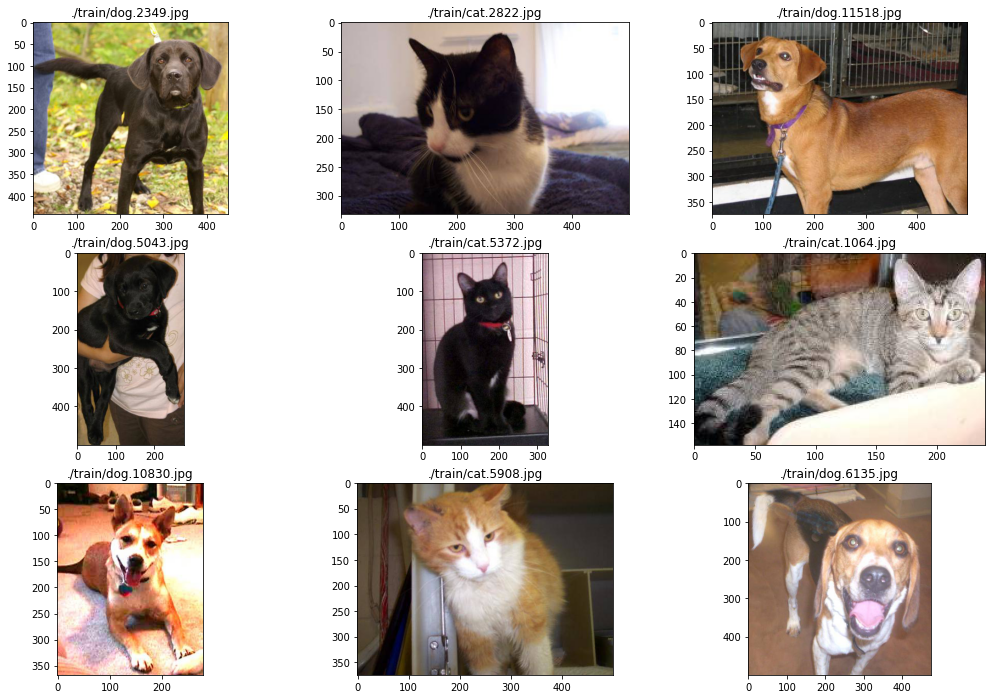

In [12]:


fig, axes = plt.subplots(nrows=3,
                         ncols=3,
                         figsize=(18, 12))
for img_path, ax in zip(train_list, axes.ravel()):
    ax.set_title(img_path)
    ax.imshow(Image.open(img_path))



In [0]:
class DogVsCatDataset(Dataset):
  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
  
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
       
        img_name = self.file_list[idx]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
    
        label_category = extract_class_from(img_name)
        label = 1 if label_category == 'dog' else 0
    
        return image, label

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [0]:
# Create training and validation datasets
image_datasets = {
    'train': DogVsCatDataset(train_list,
                             transform=data_transforms['train']),
    'val': DogVsCatDataset(val_list,
                           transform=data_transforms['val'])
}

# Create training and validation dataloaders
dataloaders_dict = {x: DataLoader(image_datasets[x],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
model_ft = models.mobilenet_v2(pretrained=True)
#model_ft.classifier[1] = nn.Linear(4096, num_classes)

In [25]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.conv.0.0.weight
	 features.1.conv.0.1.weight
	 features.1.conv.0.1.bias
	 features.1.conv.1.weight
	 features.1.conv.2.weight
	 features.1.conv.2.bias
	 features.2.conv.0.0.weight
	 features.2.conv.0.1.weight
	 features.2.conv.0.1.bias
	 features.2.conv.1.0.weight
	 features.2.conv.1.1.weight
	 features.2.conv.1.1.bias
	 features.2.conv.2.weight
	 features.2.conv.3.weight
	 features.2.conv.3.bias
	 features.3.conv.0.0.weight
	 features.3.conv.0.1.weight
	 features.3.conv.0.1.bias
	 features.3.conv.1.0.weight
	 features.3.conv.1.1.weight
	 features.3.conv.1.1.bias
	 features.3.conv.2.weight
	 features.3.conv.3.weight
	 features.3.conv.3.bias
	 features.4.conv.0.0.weight
	 features.4.conv.0.1.weight
	 features.4.conv.0.1.bias
	 features.4.conv.1.0.weight
	 features.4.conv.1.1.weight
	 features.4.conv.1.1.bias
	 features.4.conv.2.weight
	 features.4.conv.3.weight
	 features.4.conv.3.bias
	 featur

In [26]:

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)



Epoch 0/1
----------



train Loss: 0.1981 Acc: 0.9420



val Loss: 0.0551 Acc: 0.9778

Epoch 1/1
----------



train Loss: 0.0765 Acc: 0.9711



val Loss: 0.0562 Acc: 0.9792

Training complete in 4m 24s
Best val Acc: 0.979200


In [0]:
#Change path with yours
torch.save(model_ft.state_dict(), './models/cat_dog_model_ft_mnv2.pth')
torch.save(model_ft.state_dict(), './drive/My Drive/Data Set/models/cat_dog_model_ft_mnv2.pth')


Visualize training results

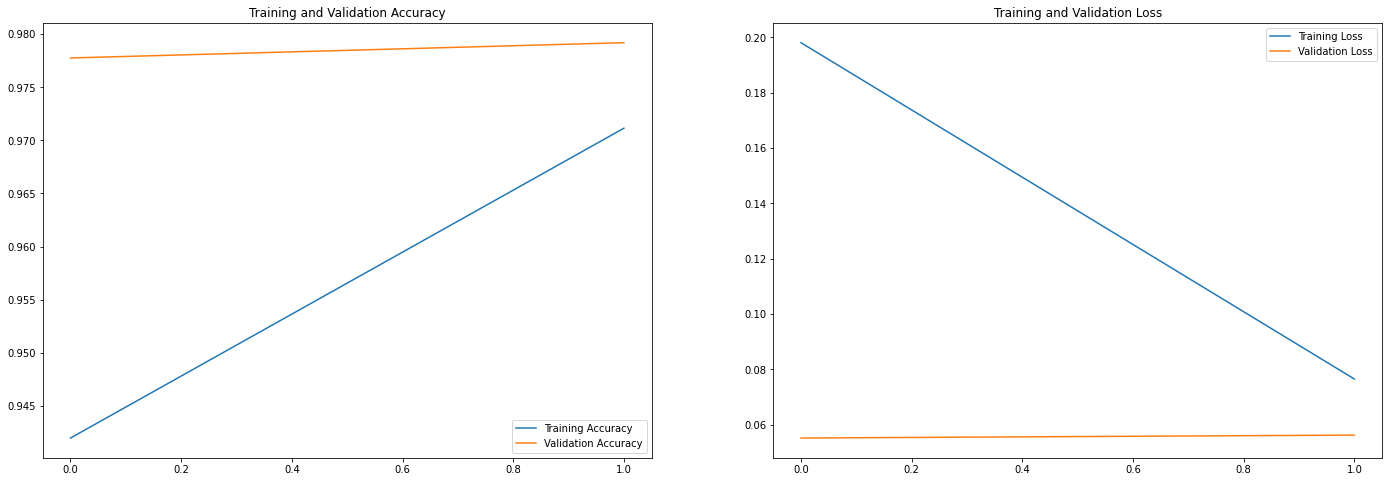

In [30]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']
epochs_range = range(num_epochs)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:

#Change path with yours
path = './models/cat_dog_model_ft_mnv2.pth'

model = model_ft  

model.load_state_dict(torch.load(path))

<All keys matched successfully>

Predict

In [32]:
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
test_data_transform = data_transforms['val']

ids = []
labels = []

with torch.no_grad():
    for test_path in tqdm(test_list):
        img = Image.open(test_path)
        img = test_data_transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)

        model_ft.eval()
        outputs = model_ft(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        test_id = extract_class_from(test_path)
        ids.append(int(test_id))
        labels.append(preds[0])

**Check Prediction** 

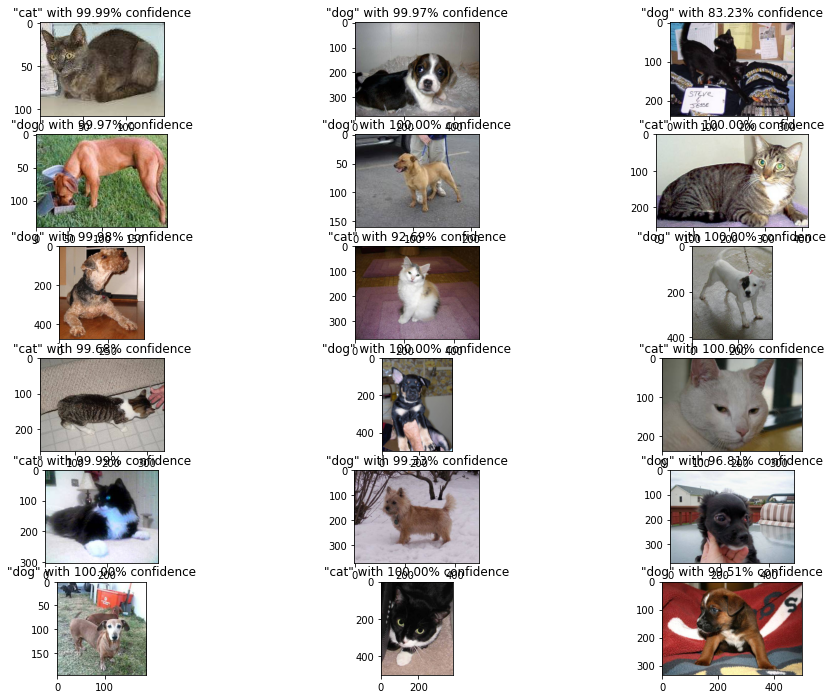

In [33]:
template = '"{}" with {:.2%} confidence'
def pred_result_message(pred):
    if pred > 0.5:
        return template.format('dog', pred)
    else:
        return template.format('cat', 1 - pred)

fig, axes = plt.subplots(nrows=6,
                         ncols=3,
                         figsize=(16, 12))
for img_path, label, ax in zip(test_list, labels, axes.ravel()):
    ax.set_title(pred_result_message(label))
    ax.imshow(Image.open(img_path))